In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pgmpy.models import DiscreteBayesianNetwork

from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
import networkx as nx
import matplotlib.pyplot as plt


In [9]:
df = pd.read_csv("heart_disease.csv")

# Drop duplicates & rows with missing values
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

# Normalize numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0.708333,1.0,1.000000,0.481132,0.244292,1.0,0.0,0.603053,0.0,0.370968,0.0,0.0,0.333333,1.0
1,0.166667,1.0,0.666667,0.339623,0.283105,0.0,0.5,0.885496,0.0,0.564516,0.0,0.0,0.666667,1.0
2,0.250000,0.0,0.333333,0.339623,0.178082,0.0,0.0,0.770992,0.0,0.225806,1.0,0.0,0.666667,1.0
3,0.562500,1.0,0.333333,0.245283,0.251142,0.0,0.5,0.816794,0.0,0.129032,1.0,0.0,0.666667,1.0
4,0.583333,0.0,0.000000,0.245283,0.520548,0.0,0.5,0.702290,1.0,0.096774,1.0,0.0,0.666667,1.0


In [10]:
# Discretize normalized columns into 3 bins (low, medium, high)
for col in ['age', 'chol', 'thalach']:
    df[col] = pd.cut(df[col], bins=3, labels=[0, 1, 2]).astype(int)

# Convert all to integers
df = df.astype(int)
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,2,1,1,0,0,1,0,1,0,0,0,0,0,1
1,0,1,0,0,0,0,0,2,0,0,0,0,0,1
2,0,0,0,0,0,0,0,2,0,0,1,0,0,1
3,1,1,0,0,0,0,0,2,0,0,1,0,0,1
4,1,0,0,0,1,0,0,2,1,0,1,0,0,1


In [14]:
from pgmpy.models import DiscreteBayesianNetwork


In [15]:
model = DiscreteBayesianNetwork([
    ('age', 'fbs'),
    ('fbs', 'target'),
    ('target', 'chol'),
    ('target', 'thalach')
])


In [16]:
model.fit(df, estimator=MaximumLikelihoodEstimator)


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'N', 'sex': 'N', 'cp': 'N', 'trestbps': 'N', 'chol': 'N', 'fbs': 'N', 'restecg': 'N', 'thalach': 'N', 'exang': 'N', 'oldpeak': 'N', 'slope': 'N', 'ca': 'N', 'thal': 'N', 'target': 'N'}


In [18]:
from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols] = discretizer.fit_transform(df[numeric_cols])


In [19]:
from pgmpy.estimators import MaximumLikelihoodEstimator

model.fit(df, estimator=MaximumLikelihoodEstimator)


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'N', 'sex': 'N', 'cp': 'N', 'trestbps': 'N', 'chol': 'N', 'fbs': 'N', 'restecg': 'N', 'thalach': 'N', 'exang': 'N', 'oldpeak': 'N', 'slope': 'N', 'ca': 'N', 'thal': 'N', 'target': 'N'}


In [23]:
print(model.edges())


[('age', 'fbs'), ('fbs', 'target'), ('target', 'chol'), ('target', 'thalach')]


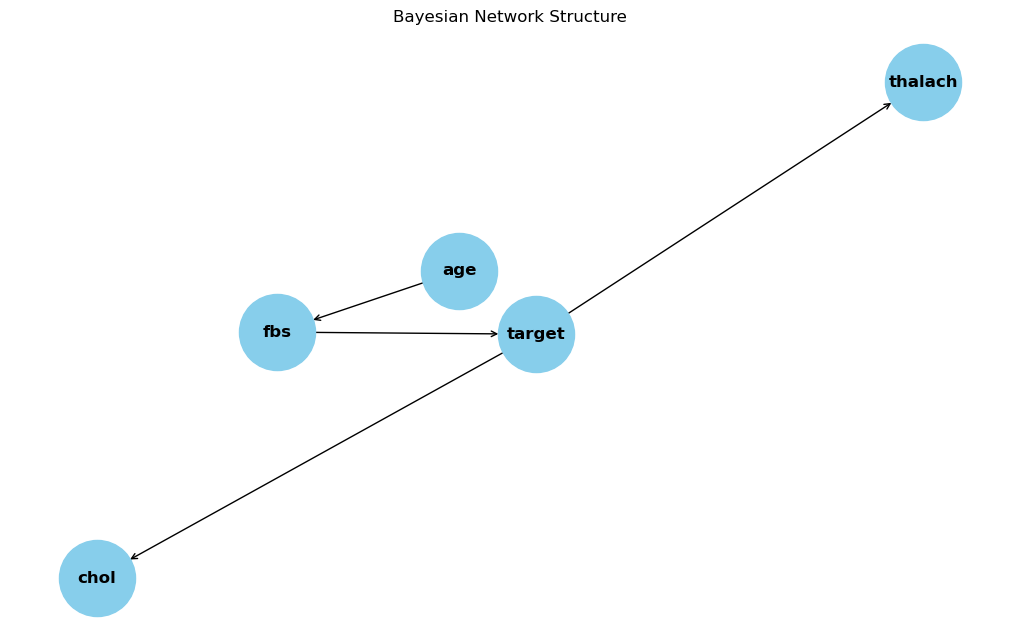

In [25]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert pgmpy model to a NetworkX DiGraph manually
G = nx.DiGraph()
G.add_edges_from(model.edges())

# Set layout
pos = nx.spring_layout(G)

# Plot
plt.figure(figsize=(10, 6))
nx.draw(G, pos,
        with_labels=True,
        node_size=3000,
        node_color='skyblue',
        font_size=12,
        font_weight='bold',
        arrows=True,
        arrowstyle='->')
plt.title("Bayesian Network Structure")
plt.show()
